![Random Unsplash Image](https://i0.wp.com/hwise-rcn.org/wp-content/uploads/2020/06/780641-1.jpg?fit=1200%2C810&ssl=1)

# features descriptions 

<ol>
 <li>ph - the acid–base balance of water. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards. At pH=7, the water is neutral, at pH less than 7 — acidic, at pH more than 7 — alkaline.</li>
 <li>
Hardness - mainly caused by calcium and magnesium salts. General guidelines for classification of waters are: 0 to 60 mg/L (milligrams per liter) as calcium carbonate is classified as soft; 61 to 120 mg/L as moderately hard; 121 to 180 mg/L as hard; and more than 180 mg/L as very hard.</li>
 <li>Solids - water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.</li>
  <li>Chloramines - chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.</li>
  <li> Sulfate - sulfates are naturally occurring substances that are found in minerals, soil, and rocks. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.</li>
  <li> Conductivity - pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.
</li>
  <li>Organic_carbon - total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.</li>
  <li> Trihalomethanes - THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. The legal limit of total THMs in drinking water in Europe is 100 ppm.</li>
</ol>

In [ ]:
!pip install hyperopt
!pip install mlflow

In [ ]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.feature_selection import f_classif, chi2

from sklearn.model_selection import cross_val_score, cross_validate
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from scipy.stats import shapiro

In [1]:
data= pd.read_csv("water_potability.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 ph 2785 non-null float64
 1 Hardness 3276 non-null float64
 2 Solids 3276 non-null float64
 3 Chloramines 3276 non-null float64
 4 Sulfate 2495 non-null float64
 5 Conductivity 3276 non-null float64
 6 Organic_carbon 3276 non-null float64
 7 Trihalomethanes 3114 non-null float64
 8 Turbidity 3276 non-null float64
 9 Potability 3276 non-null int64 
dtypes: float64(9), int64(1)
memory usage: 256.1 KB

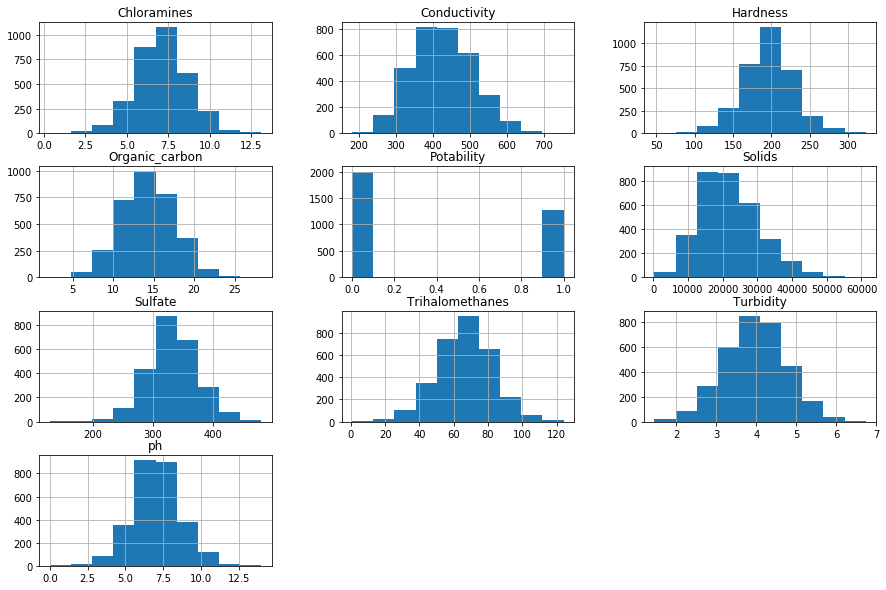

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
data.hist(grid=True,ax=ax)

In [2]:
##################################### Imputing 'ph' value #####################################

phMean_0 = data[data['Potability'] == 0]['ph'].mean(skipna=True)
data.loc[(data['Potability'] == 0) & (data['ph'].isna()), 'ph'] = phMean_0
phMean_1 = data[data['Potability'] == 1]['ph'].mean(skipna=True)
data.loc[(data['Potability'] == 1) & (data['ph'].isna()), 'ph'] = phMean_1

##################################### Imputing 'Sulfate' value #####################################

SulfateMean_0 = data[data['Potability'] == 0]['Sulfate'].mean(skipna=True)
data.loc[(data['Potability'] == 0) & (data['Sulfate'].isna()), 'Sulfate'] = SulfateMean_0
SulfateMean_1 = data[data['Potability'] == 1]['Sulfate'].mean(skipna=True)
data.loc[(data['Potability'] == 1) & (data['Sulfate'].isna()), 'Sulfate'] = SulfateMean_1

################################ Imputing 'Trihalomethanes' value #####################################

TrihalomethanesMean_0 = data[data['Potability'] == 0]['Trihalomethanes'].mean(skipna=True)
data.loc[(data['Potability'] == 0) & (data['Trihalomethanes'].isna()), 'Trihalomethanes'] = TrihalomethanesMean_0
TrihalomethanesMean_1 = data[data['Potability'] == 1]['Trihalomethanes'].mean(skipna=True)
data.loc[(data['Potability'] == 1) & (data['Trihalomethanes'].isna()), 'Trihalomethanes'] = TrihalomethanesMean_1

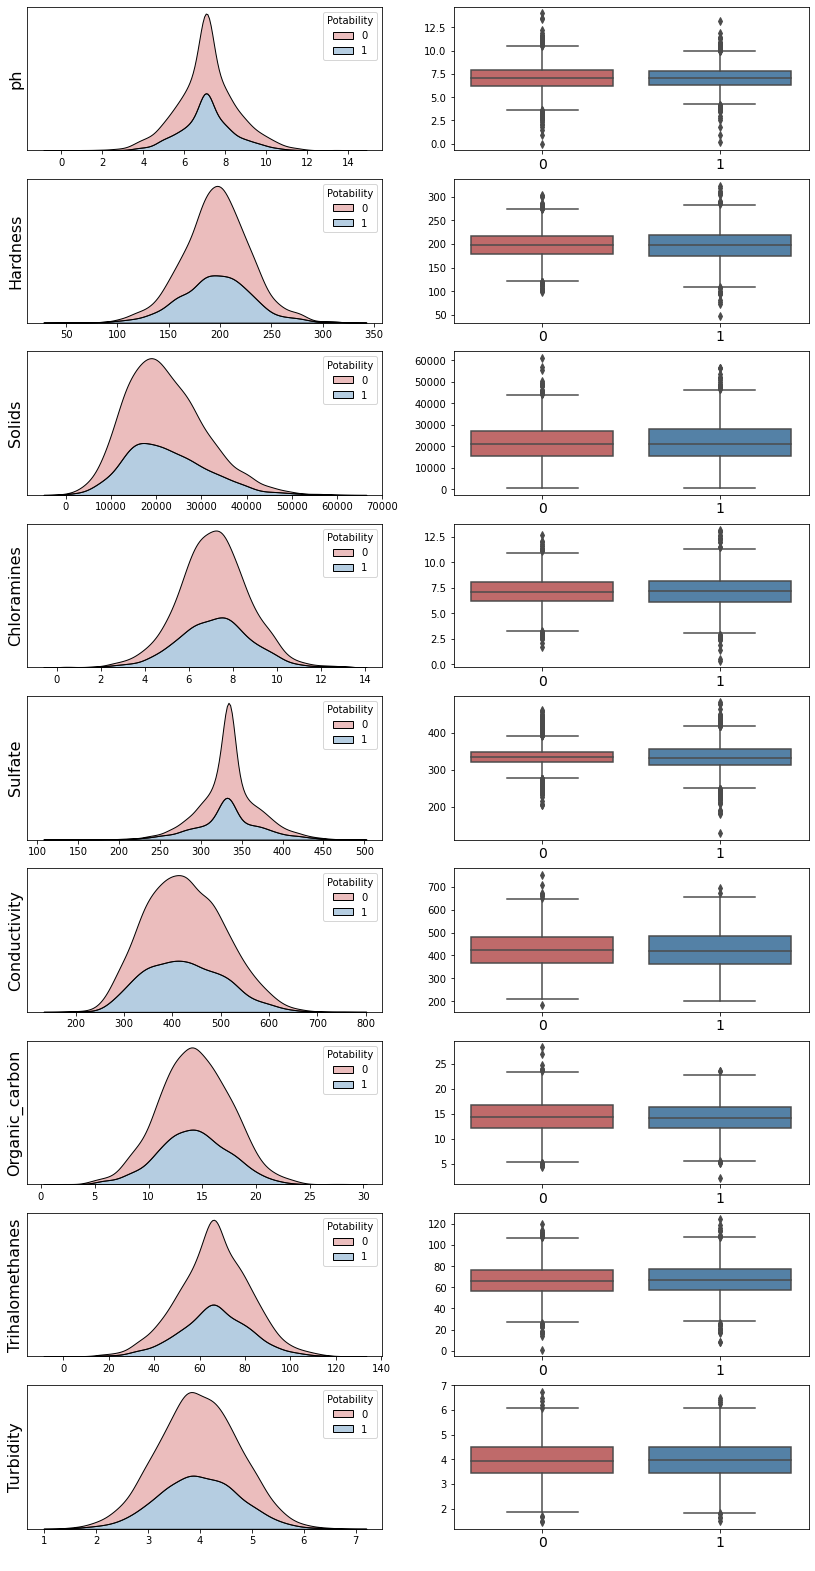

In [3]:
#print('Boxplot and density distribution of different features by Potability\n')

fig, ax = plt.subplots(ncols=2, nrows=9, figsize=(14, 28))

features = list(data.columns.drop('Potability'))
i=0
for cols in features:
    sns.kdeplot(data[cols], fill=True, alpha=0.4, hue = data.Potability, 
                palette=('indianred', 'steelblue'), multiple='stack', ax=ax[i,0])
    
    sns.boxplot(data= data, y=cols, x='Potability', ax=ax[i, 1],
               palette=('indianred', 'steelblue'))
    ax[i,0].set_xlabel(' ')
    ax[i,1].set_xlabel(' ')
    ax[i,1].set_ylabel(' ')
    ax[i,1].xaxis.set_tick_params(labelsize=14)
    ax[i,0].tick_params(left=False, labelleft=False)
    ax[i,0].set_ylabel(cols, fontsize=16)
    i=i+1
plt.show()

We can't see any big difference in mean values of the features among the levels of Potability.! Seems this is not real data

In [ ]:
data.corr().style.background_gradient(cmap='coolwarm')

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075878,-0.081887,-0.031827,0.014785,0.017205,0.040092,0.003009,-0.036211,-0.003848
Hardness,0.075878,1.000000,-0.046899,-0.030054,-0.092718,-0.023915,0.003610,-0.012718,-0.014449,-0.013837
Solids,-0.081887,-0.046899,1.000000,-0.070148,-0.149809,0.013831,0.010242,-0.008849,0.019546,0.033743
Chloramines,-0.031827,-0.030054,-0.070148,1.000000,0.023490,-0.020486,-0.012653,0.016615,0.002363,0.023779
Sulfate,0.014785,-0.092718,-0.149809,0.023490,1.000000,-0.014196,0.027403,-0.025797,-0.009523,-0.026957
Conductivity,0.017205,-0.023915,0.013831,-0.020486,-0.014196,1.000000,0.020966,0.001238,0.005798,-0.008128
Organic_carbon,0.040092,0.003610,0.010242,-0.012653,0.027403,0.020966,1.000000,-0.012944,-0.027308,-0.030001
Trihalomethanes,0.003009,-0.012718,-0.008849,0.016615,-0.025797,0.001238,-0.012944,1.000000,-0.021540,0.007305
Turbidity,-0.036211,-0.014449,0.019546,0.002363,-0.009523,0.005798,-0.027308,-0.021540,1.000000,0.001581
Potability,-0.003848,-0.013837,0.033743,0.023779,-0.026957,-0.008128,-0.030001,0.007305,0.001581,1.000000


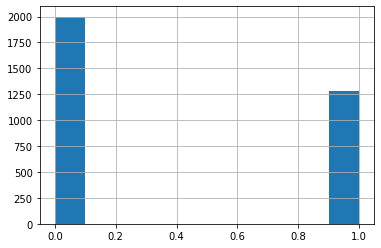

In [ ]:
data['Potability'].hist()

In [ ]:
under = RandomUnderSampler(sampling_strategy=0.9)
X, y = under.fit_resample(data.iloc[:,:-1], data.iloc[:,-1])

# Let's train some models

In [ ]:
## standard scaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=data.columns[:-1])

In [ ]:
# https://towardsdatascience.com/mistakes-in-applying-univariate-feature-selection-methods-34c43ce8b93d

# Our features are continous
# as our target is categorical we can perform a ANOVA Test to check an linear depencies between features and the target
N_continuous = 5
N_categorical = 5

f_scores = f_classif(X_scaled_df.values,y)
_, p = f_scores
most_f = p.argsort()
most_dependent_numerical_variables = [X_scaled_df.columns[element] for element in most_f[:N_continuous]]

most_dependent_numerical_variables

Out[102]: ['Solids', 'Organic_carbon', 'Chloramines', 'Hardness', 'Conductivity']

In [ ]:
### Select the most important features

X_selected = X_scaled_df[most_dependent_numerical_variables]
               
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
  X_selected,
  y,
  test_size=0.2,
  random_state=0
)


In [ ]:
with mlflow.start_run(run_name='logistic_regression') as run:
  model = LogisticRegression(C=0.2, class_weight='None', penalty='l2',
                   solver='saga',random_state=0)
  
  # Models, parameters, and training metrics are tracked automatically
  model.fit(X_train, y_train)

  predicted_probs = model.predict_proba(X_test)
  roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
  
  # The AUC score on test data is not automatically logged, so log it manually
  mlflow.log_metric("test_auc", roc_auc)
  print("Test AUC of: {}".format(roc_auc))

Test AUC of: 0.5360288948014172

# Train LR model with MLflow (all features)

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
  X_selected,
  y,
  test_size=0.2,
  random_state=0
)

In [ ]:
with mlflow.start_run(run_name='logistic_regression') as run:
  model =LogisticRegression(random_state=0)
  
  # Models, parameters, and training metrics are tracked automatically
  model.fit(X_train, y_train)

  predicted_probs = model.predict_proba(X_test)
  roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
  
  # The AUC score on test data is not automatically logged, so log it manually
  mlflow.log_metric("test_auc", roc_auc)
  print("Test AUC of: {}".format(roc_auc))

Test AUC of: 0.5173447360822758

### GreadSearch+Logistic Regression

In [ ]:
# GridSearch
param={'solver':('Newton-cg','lbfgs','liblinear', 'sag', 'saga'),'penalty':('l1', 'l2', 'elasticnet', 'none'),
       'n_jobs':(-1,1,2,3),'class_weight':('balanced','None'),
       'C':(0.2, 0.1, 0.15, 0.12, 0.3, 0.4, 0.6, 0.5, 1, 1.2, .3, 1.4, 1.5),
       'max_iter':(100, 150, 200)}

h = GridSearchCV(LogisticRegression(), param, cv=5, n_jobs=5).fit(X_train, y_train)

h.best_estimator_

Out[81]: LogisticRegression(C=0.1, class_weight='None', n_jobs=-1, penalty='l1',
 solver='saga')

In [ ]:
with mlflow.start_run(run_name='logistic_regression') as run:
  model =LogisticRegression(C=0.1, class_weight='None', penalty='l1',
                   solver='saga',random_state=0)
  
  # Models, parameters, and training metrics are tracked automatically
  model.fit(X_train, y_train)

  predicted_probs = model.predict_proba(X_test)
  roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
  
  # The AUC score on test data is not automatically logged, so log it manually
  mlflow.log_metric("test_auc", roc_auc)
  print("Test AUC of: {}".format(roc_auc))

Test AUC of: 0.5159423079567171

# Gradient boosting

### Gradient Boosting with MLflow

In [ ]:
with mlflow.start_run(run_name='gradient_boost') as run:
  model_2 = sklearn.ensemble.GradientBoostingClassifier(
    random_state=0, 
    
    # Try a new parameter setting for n_estimators
    n_estimators=200,
  )
  model_2.fit(X_train, y_train)

  predicted_probs = model_2.predict_proba(X_test)
  roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
  mlflow.log_metric("test_auc", roc_auc)
  print("Test AUC of: {}".format(roc_auc))

Test AUC of: 0.6312851466362349

### Parallel training with Hyperopt and SparkTrials

In [ ]:
def train_model(params):
  # Enable autologging on each worker
  mlflow.autolog()
  with mlflow.start_run(nested=True):
    model_hp = sklearn.ensemble.GradientBoostingClassifier(
      random_state=0,
      **params
    )
    model_hp.fit(X_train, y_train)
    predicted_probs = model_hp.predict_proba(X_test)
    # Tune based on the test AUC
    # In production settings, you could use a separate validation set instead
    roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
    mlflow.log_metric('test_auc', roc_auc)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*roc_auc}

# SparkTrials distributes the tuning using Spark workers
# Greater parallelism speeds processing, but each hyperparameter trial has less information from other trials
# On smaller clusters or Databricks Community Edition try setting parallelism=2
spark_trials = SparkTrials(
  parallelism=2
)

search_space = {
  'n_estimators': scope.int(hp.quniform('n_estimators', 20, 1000, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
}


with mlflow.start_run(run_name='gb_hyperopt') as run:
  # Use hyperopt to find the parameters yielding the highest AUC
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=32,
    trials=spark_trials)

0%| | 0/32 [00:00<?, ?trial/s, best loss=?] 3%|▎ | 1/32 [00:08<04:08, 8.02s/trial, best loss: -0.888369471064608] 6%|▋ | 2/32 [00:12<02:49, 5.66s/trial, best loss: -0.888369471064608] 9%|▉ | 3/32 [00:17<02:35, 5.36s/trial, best loss: -0.8888369471064608] 12%|█▎ | 4/32 [00:20<02:04, 4.43s/trial, best loss: -0.897334011631904]  16%|█▌ | 5/32 [00:27<02:24, 5.36s/trial, best loss: -0.897334011631904] 19%|█▉ | 6/32 [00:31<02:07, 4.90s/trial, best loss: -0.897334011631904] 22%|██▏ | 7/32 [00:35<01:55, 4.61s/trial, best loss: -0.897334011631904] 25%|██▌ | 8/32 [00:37<01:30, 3.78s/trial, best loss: -0.897897732741197] 28%|██▊ | 9/32 [00:42<01:35, 4.16s/trial, best loss: -0.897897732741197] 31%|███▏ | 10/32 [00:43<01:10, 3.19s/trial, best loss: -0.897897732741197] 38%|███▊ | 12/32 [00:51<01:11, 3.57s/trial, best loss: -0.897897732741197] 41%|████ | 13/32 [00:57<01:19, 4.18s/trial, best loss: -0.897897732741197] 44%|████▍ | 14/32 [00:58<01:00, 3.35s/trial, best loss: -0.897897732741197] 47%|████▋ | 15/32 [01:07<01:23, 4.90s/trial, best loss: -0.897897732741197] 50%|█████ | 16/32 [01:09<01:05, 4.08s/trial, best loss: -0.897897732741197] 53%|█████▎ | 17/32 [01:15<01:09, 4.64s/trial, best loss: -0.897897732741197] 56%|█████▋ | 18/32 [01:18<00:58, 4.16s/trial, best loss: -0.897897732741197] 59%|█████▉ | 19/32 [01:23<00:57, 4.41s/trial, best loss: -0.897897732741197] 62%|██████▎ | 20/32 [01:26<00:48, 4.00s/trial, best loss: -0.897897732741197] 66%|██████▌ | 21/32 [01:28<00:37, 3.41s/trial, best loss: -0.897897732741197] 69%|██████▉ | 22/32 [01:38<00:53, 5.38s/trial, best loss: -0.897897732741197] 72%|███████▏ | 23/32 [01:40<00:39, 4.38s/trial, best loss: -0.897897732741197] 75%|███████▌ | 24/32 [01:45<00:36, 4.57s/trial, best loss: -0.897897732741197] 78%|███████▊ | 25/32 [01:46<00:24, 3.50s/trial, best loss: -0.897897732741197] 81%|████████▏ | 26/32 [01:52<00:25, 4.26s/trial, best loss: -0.897897732741197] 84%|████████▍ | 27/32 [01:53<00:16, 3.29s/trial, best loss: -0.897897732741197] 88%|████████▊ | 28/32 [01:58<00:15, 3.81s/trial, best loss: -0.897897732741197] 91%|█████████ | 29/32 [02:00<00:09, 3.27s/trial, best loss: -0.897897732741197] 97%|█████████▋| 31/32 [02:08<00:03, 3.61s/trial, best loss: -0.897897732741197]100%|██████████| 32/32 [02:13<00:00, 3.96s/trial, best loss: -0.897897732741197]100%|██████████| 32/32 [02:13<00:00, 4.17s/trial, best loss: -0.897897732741197]
Total Trials: 32: 32 succeeded, 0 failed, 0 cancelled.

## best model

In [ ]:
# Sort runs by their test auc; in case of ties, use the most recent run
best_run = mlflow.search_runs(
  order_by=['metrics.test_auc DESC', 'start_time DESC'],
  max_results=10,
).iloc[0]
print('Best Run')
print('AUC: {}'.format(best_run["metrics.test_auc"]))
print('Num Estimators: {}'.format(best_run["params.n_estimators"]))
print('Max Depth: {}'.format(best_run["params.max_depth"]))
print('Learning Rate: {}'.format(best_run["params.learning_rate"]))

Best Run
AUC: 0.897897732741197
Num Estimators: 137
Max Depth: 3
Learning Rate: 0.18293110635043114

### Metrics for test and train

In [ ]:
clf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=137, learning_rate=0.18,max_depth=3, random_state=0)

scoring = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']

result = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring, return_estimator=True)

print("Accuracy confidence interval: {} +- {}".format(result['test_accuracy'].mean(), result['test_accuracy'].std()))
print("ROC AUC confidence interval: {} +- {}".format(result['test_roc_auc'].mean(), result['test_roc_auc'].std()))
print("F1 confidence interval: {} +- {}".format(result['test_f1'].mean(), result['test_f1'].std()))
print("Precison confidence interval: {} +- {}".format(result['test_precision'].mean(), result['test_precision'].std()))
print("Recall confidence interval: {} +- {}".format(result['test_recall'].mean(), result['test_recall'].std()))

Accuracy confidence interval: 0.7557779066769786 +- 0.015148914945866338
ROC AUC confidence interval: 0.851513477747126 +- 0.014309068923724353
F1 confidence interval: 0.7351799994062465 +- 0.020865420657431587
Precison confidence interval: 0.7540693222723859 +- 0.010876099762018502
Recall confidence interval: 0.7179387852702057 +- 0.035160929209478824

In [ ]:
clf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=137, learning_rate=0.18,max_depth=3, random_state=0)

scoring = ['accuracy', 'roc_auc', 'f1', 'precision', 'recall']

result = cross_validate(clf, X_test, y_test, cv=5, scoring=scoring, return_estimator=True)

print("Accuracy confidence interval: {} +- {}".format(result['test_accuracy'].mean(), result['test_accuracy'].std()))
print("ROC AUC confidence interval: {} +- {}".format(result['test_roc_auc'].mean(), result['test_roc_auc'].std()))
print("F1 confidence interval: {} +- {}".format(result['test_f1'].mean(), result['test_f1'].std()))
print("Precison confidence interval: {} +- {}".format(result['test_precision'].mean(), result['test_precision'].std()))
print("Recall confidence interval: {} +- {}".format(result['test_recall'].mean(), result['test_recall'].std()))

Accuracy confidence interval: 0.7481481481481481 +- 0.014814814814814814
ROC AUC confidence interval: 0.8228959465027575 +- 0.012459624826211385
F1 confidence interval: 0.7310183251334842 +- 0.018523100808185682
Precison confidence interval: 0.7429283559577676 +- 0.01319145550319015
Recall confidence interval: 0.7199095022624434 +- 0.028146388694309372